In [1]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re


In [2]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bhtsne import tsne

In [3]:
# get pretrained word vectors trained  on the entire GoT text using word2vec in gensim

thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

In [4]:
# get all word vectors
all_word_vecs = thrones2vec.syn0

### What patterns do we see if we average a set of similar/related words(names) and find the words with highest cosine similarity with our average vector?

In [9]:
def best_avgs(words, all_vecs,k=10):
    
    from operator import itemgetter
    
    ## get word embeddings for the words in our input array
    embs = np.array([thrones2vec[word] for word in words])
    
    #calculate its average
    avg = np.sum(embs,axis=0)/len(words)
    
    # Cosine Similarity with every word vector in the corpus
    denom = np.sqrt(np.sum(all_vecs*all_vecs,axis=1,keepdims=True)) \
            * np.sqrt(np.sum(avg*avg))
        
    similarity = all_vecs.dot(avg.T).reshape(all_vecs.shape[0],1) \
           / denom
    similarity = similarity.reshape(1,all_vecs.shape[0])[0]
    
    # Finding the 10 largest words with highest similarity
    # Since we are averaging we might end up getting the input words themselves 
    # among the top values
    # we need to make sure we get back len(words)+k closest words and then 
    # remove all input words we supplied
    
    nClosest = k + len(words)
    
    # Get indices of the most similar word vectors to our avgvector
    ind = np.argpartition(similarity, -(nClosest))[-nClosest:]
    
    names = [thrones2vec.index2word[indx] for indx in ind]
    similarity = similarity[ind]
    uniq = [(person,similar) for person,similar in zip(names,similarity) if person not in words]
    
          
    return sorted(uniq,key=itemgetter(1),reverse=True)[:k]

## Let's see what we get

We will supply the names of all the children of Ned and Catelyn Stark and see what we get back as best avgs

In [8]:
children = ["Arya","Robb","Sansa","Bran","Jon"]

best_avgs(children, all_word_vecs, 10)

[('Ned', 0.77162558),
 ('Catelyn', 0.7651071),
 ('Theon', 0.76012158),
 ('Marillion', 0.74658471),
 ('Denyo', 0.73677385),
 ('Meera', 0.73632461),
 ('miserably', 0.73278576),
 ('Alayne', 0.73019749),
 ('resentfully', 0.72818333),
 ('abashed', 0.72270644)]

And the top two best averages? Their parents: Ned and Catelyn.
Math is Beautiful :)

### See if we can get some context about two families from their best average vectors

In [10]:
families = ["Lannister","Stark"]
best_avgs(families, all_word_vecs, 10)

[('Eddard', 0.73663378),
 ('prisoner', 0.67867976),
 ('executed', 0.66524822),
 ('Kingslayer', 0.65539443),
 ('beheaded', 0.65496331),
 ('Larmister', 0.65430796),
 ('Lyanna', 0.65174305),
 ('Tully', 0.65099597),
 ('proclaim', 0.64551753),
 ('nephew', 0.64184773)]

*Spoilers*

In [32]:
families = ["Tully","Stark"]
best_avgs(families, all_word_vecs, 10)

[('Eddard', 0.75434911),
 ('CATELYN', 0.71656168),
 ('Edmure', 0.70498776),
 ('Alys', 0.69106424),
 ('Rickard', 0.68881041),
 ('ROSLIN', 0.68863809),
 ('Karstark', 0.68640965),
 ('Blackwood', 0.68613464),
 ('Lyanna', 0.68546879),
 ('executed', 0.68536949)]

#### Model correctly predicted the relationship between the Two Families

In [11]:
families = ["Lannister","Baratheon"]
best_avgs(families, all_word_vecs, 10)

[('Larmister', 0.71346289),
 ('rebel', 0.70376235),
 ('usurper', 0.6892702),
 ('Tywin', 0.68925124),
 ('Renly', 0.68860513),
 ('scorn', 0.6855734),
 ('marshaling', 0.6845808),
 ('proclaim', 0.6828925),
 ('executed', 0.68053156),
 ('condition', 0.67621481)]

Who's the usurper? *a person who takes a position of power or importance illegally or by force.*

In [14]:
thrones2vec.most_similar("usurper")

[('denies', 0.8773535490036011),
 ('governance', 0.8747445344924927),
 ('contest', 0.8730944991111755),
 ('bleeds', 0.8654630184173584),
 ('staunchest', 0.8634561896324158),
 ('forfeit', 0.8627853989601135),
 ('deserter', 0.8614746928215027),
 ('assuming', 0.8605493307113647),
 ('duel', 0.860111653804779),
 ('downfall', 0.8598672151565552)]

Here we obtain words that are used in the same context as usurper or than have some similarity of usage with it. So the model is able to capture this kind of relationship as well.


In [38]:
thrones2vec.most_similar("Tyrion")

[('Jaime', 0.7467867732048035),
 ('Cersei', 0.6738306283950806),
 ('Kevan', 0.6644669771194458),
 ('dwarf', 0.6351081132888794),
 ('Littlefinger', 0.6318366527557373),
 ('Griff', 0.6017279624938965),
 ('Quentyn', 0.5892155170440674),
 ('Bronn', 0.5891206860542297),
 ('Shae', 0.588775634765625),
 ('Brorm', 0.5874122381210327)]

In [43]:
thrones2vec.most_similar("Dothraki")

[('khal', 0.7836271524429321),
 ('khalasar', 0.7041406631469727),
 ('horselords', 0.7036888599395752),
 ('bloodriders', 0.702080249786377),
 ('Qartheen', 0.6937009692192078),
 ('Drogo', 0.6921443939208984),
 ('fashion', 0.6732668280601501),
 ('Khal', 0.6719760894775391),
 ('slavers', 0.6688367128372192),
 ('handmaids', 0.6488291025161743)]

In [20]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [30]:
nearest_similarity_cosmul("woman","man","king")

woman is related to man, as queen is related to king


'queen'

In [49]:
nearest_similarity_cosmul("Jaime","Lannister","Stark")

Jaime is related to Lannister, as Bran is related to Stark


'Bran'

In [46]:
thrones2vec.most_similar("Jaime")

[('Kevan', 0.759272038936615),
 ('Tyrion', 0.7467868328094482),
 ('Joff', 0.701489269733429),
 ('Lancel', 0.6998273730278015),
 ('Brienne', 0.6797164678573608),
 ('Bronn', 0.6679006218910217),
 ('Cersei', 0.664563775062561),
 ('Brorm', 0.6595182418823242),
 ('Esgred', 0.6494612693786621),
 ('Peck', 0.6482341289520264)]

### Arya - John + Ghost = ?

In [70]:
thrones2vec.most_similar(positive=['Ghost', 'Arya'], negative=['Jon'])

[('Nymeria', 0.6201437711715698),
 ('sullenly', 0.617594838142395),
 ('crying', 0.5993787050247192),
 ('Meera', 0.5924408435821533),
 ('Dancer', 0.5818844437599182),
 ('uncertainly', 0.5813841819763184),
 ('Shaggydog', 0.5813510417938232),
 ('Gendry', 0.57976895570755),
 ('whimpered', 0.5790257453918457),
 ('Needle', 0.578599750995636)]

## Dimensionality reduction using tsne

In [6]:
Y = tsne(all_word_vecs.astype('float64'))

In [112]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, Y[thrones2vec.vocab[word].index])
            for word in thrones2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [113]:
points.head(10)

,word,x,y
0,gaoler,24.651529,-5.125494
1,training,19.900935,10.178691
2,forewarned,12.767958,4.261016
3,commonly,15.569672,6.315326
4,CERENNA,30.714753,11.463898
5,regrouped,-9.406484,12.894604
6,whit,5.788325,-2.995574
7,nothing,9.379431,-23.883297
8,Andal,8.162145,2.014612
9,treasonous,14.569912,-12.187842


In [114]:
sns.set_context("poster")

In [115]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


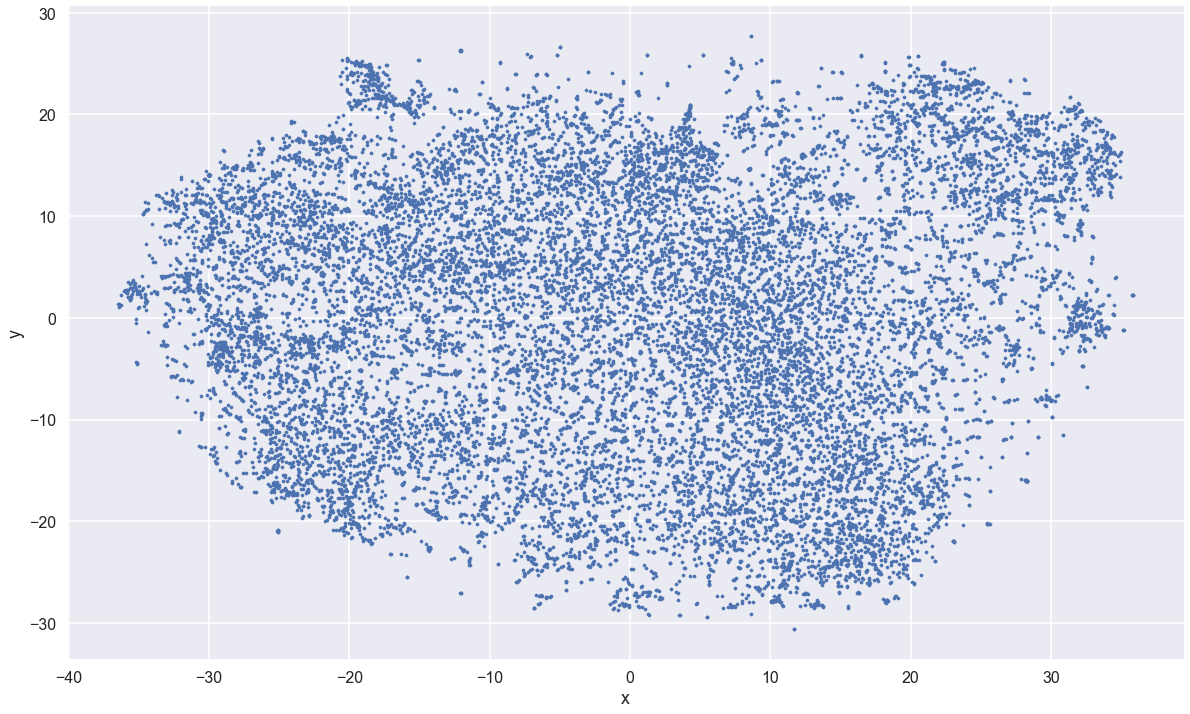

In [116]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [117]:

def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    inwords=[]
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        inwords.append(point.word)
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
    print(", ".join(inwords))

Rakharo, bath, Jhogo, Dorcas, Irri, Jocelyn, Missandei, handmaid, Aggo, Jhiqui, Doreah


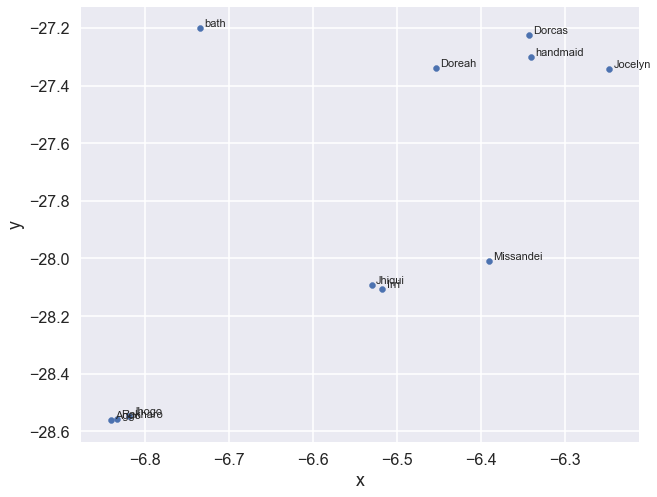

In [118]:
plot_region(x_bounds=(-8.0,-6.0), y_bounds=(-29.0, -26.0))

In [119]:
points.loc[points["word"]=="Jaime",:]

,word,x,y
16237,Jaime,30.845132,-3.247683


Boy, Lannister, Kevan, Petyr, Orton, Hyle, Waters, Slynt, Belwas, Megga, Strong, Lancel, Baelish, Suggs, Alla, Gerris, Arstan, Piggy, Grandfather, Drinkwater, Creighton, Hunt, Janos, Whitebeard, Tyrion, Shadrich, fucking, Podrick, Jaime, Elinor, Aurane


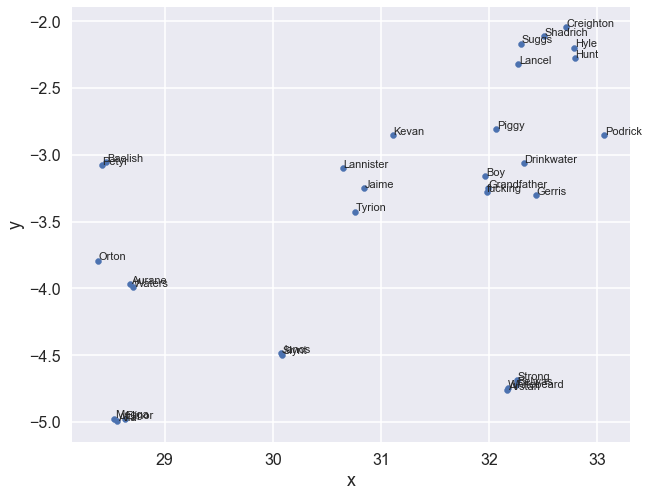

In [120]:
plot_region(x_bounds=(28,34), y_bounds=(-5.0,-2.0))

In [87]:
def coords(word):
    coord = points.loc[points["word"]==word,:].values[0]
    return coord[1],coord[2]

In [80]:
coords("Jon")

(-7.304396800809434, -23.692716737561867)

In [82]:
def plot_close_to(word):
    x,y = coords(word)
    plot_region(x_bounds=(x-1.0,x+1.0), y_bounds=(y-1.0,y+1.0))
    
   

beets, honey, olives, savory, pickled, spiced, fried, cloves, stew, turnips, spices, pease, carrots, baked, bacon, bread, venison, peppers, stewed, honeyed, eggs, fruit, stale, pies, pepper, beans, roast, beef, pork, mushrooms, herbs, salt, mutton, roasted, figs, fish, fresh, butter, stuffed, cooked, onions, barley, ham, cod, garlic, apples


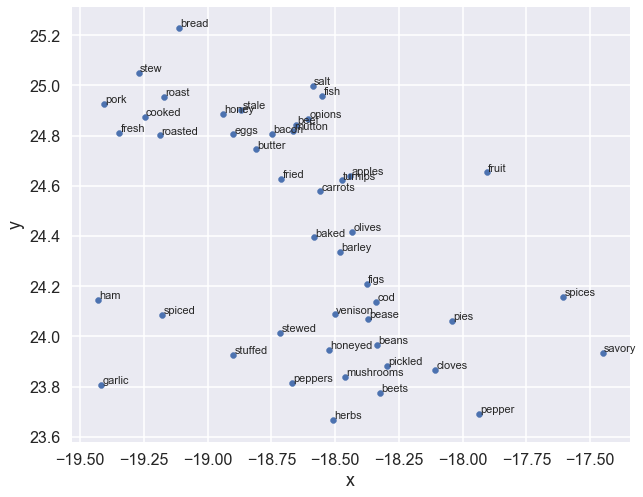

In [121]:
plot_close_to("apples")

sons, Winterfell, Duskendale, Maidenpool, Moat, Harrenhal, Cailin, Bitterbridge, Dreadfort, daughters, northmen, Freys, Boltons, grandsons


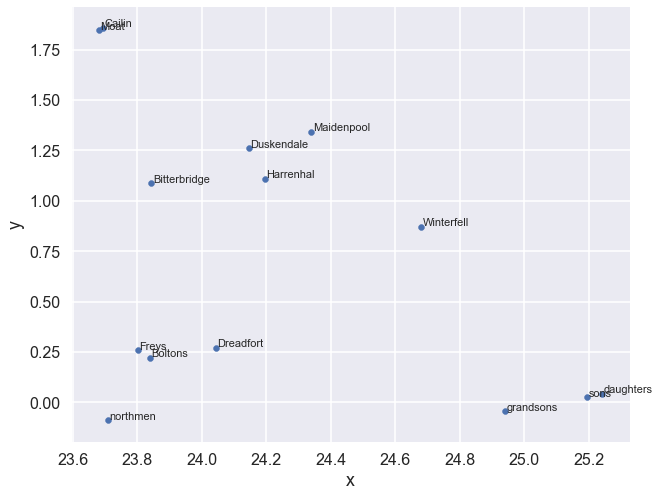

In [106]:
plot_close_to("Winterfell")

Moore, Ilyn, Dontos, Lothor, Osfryd, Thorne, Oakheart, Brune, Loras, Osmund, Mandon, Alliser, Osney, Meryn, Selmy, Barristan, Jorah, Waymar, Trant, Boros, Payne, Vardis, Arys, Axell, Blount, Mormont, Kettleblack, Ser, Preston


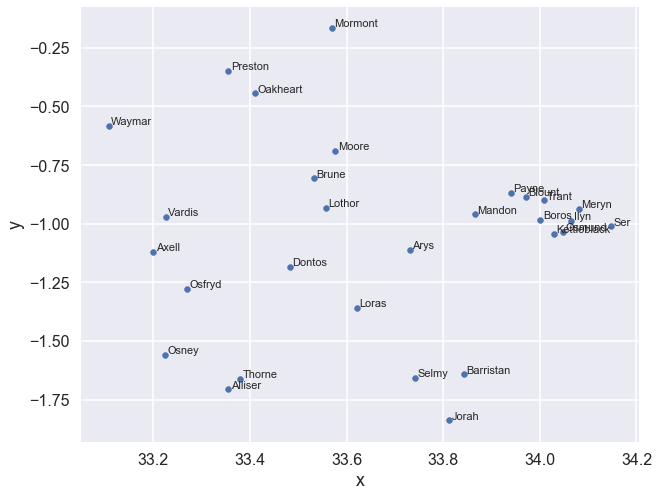

In [108]:
plot_close_to("Payne")

In [122]:
for i in ["king","queen","man","woman"]:
    print(coords(i))

(20.547051370317167, -14.59046239544781)
(22.778798942566624, -11.741200389155026)
(2.89685063809792, -13.87755675145707)
(2.098319070677097, -14.501805965274665)


cry, scream, wishing, herself, sobbing, dizzy, barely, feel, breathe, Needle, sniff, feeling, gasp, felt, shout, sob


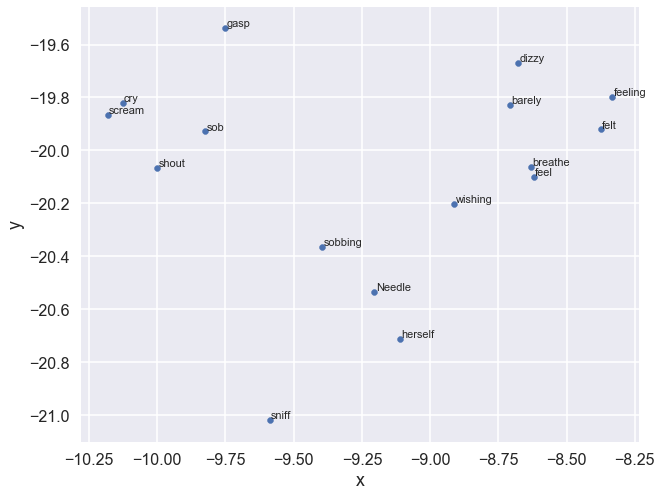

In [124]:
plot_close_to("Needle")